<a href="https://colab.research.google.com/github/python4phys1cs/physics-problems/blob/main/calculating-bandgap/lstsq_znse_znsse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating the bangap of material from transmittance data

Importing necessary libraries and modules

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from matplotlib import style

plt.style.use('seaborn-poster')

Follwing function loads the transmittance data using `loadtxt` from `numpy`

The transmittance values were converted to absolute values
$$T = \frac{T\%}{100}$$

Absorption coefficient was calculated using expression
$$\alpha = - \frac{ln(T)}{t}$$
where $t$ is the thickness of sample

Energy of photon was calculated using formula
$$E = h \nu \hspace{1cm} \Rightarrow \hspace{1cm} E = \frac{h c}{\lambda}$$

$(\alpha h \nu)^2$ values were calculated and smoothened using a fourth order Savitzsky-Golay filter.
The data was rescaled by dividing with the maximum value.

The function returns $h \nu$ and rescaled $(\alpha h \nu)^2$ values

In [ ]:
#function to get data to required format
def dataformat(datafile):  
  wavelength_data, T_data = np.loadtxt(datafile, dtype='object', delimiter=',', unpack=True)
  wavelength_data = wavelength_data.astype('float64')
  T_data = T_data.astype('float64')
  #T = T%/100
  T = T_data/100
  wavelength = wavelength_data*1e-9
  h = 6.626e-34 #planck's constant
  c = 3e8 #velocity of light
  eV = 1.602e-19 #1 electron-volt

  E = h*c/(wavelength*eV)
  t = 2e-7 #thickness of sample in meter

  alpha = - np.log(T)/t
  #setting power for direct or indirect semiconductor
  n=2

  #evaluating the values for Tauc Plot
  TP = (alpha*E)**n
  #smoothening the data using Savitzky-Golay Filter
  sg = savgol_filter(TP, 9, 4)
  #calculating the maximum value of Tauc plot for rescaling
  sgmax = max(sg)

  #rescaling the Tauc plot
  sgre = sg/sgmax

  return E, sgre

Following function applies **segmentation** algorithm to evaluate bandgap of material.

The function returns bandgap of material, slope of selected line and root mean square error corresponding to given length of segment.

In [ ]:
#function to implement segmentation algorithm
def segmentation(L, E, sgre):  
  #initiating arrays to store values
  rmse = []
  slope = []
  intercept = []

  for i in range(len(E)):
    #calculating slope and intercept of line for every L points
    if i + L <= len(E):
      A = np.vstack([E[i:i+L], np.ones(len(E[i:i+L]))]).T
      m, b = np.linalg.lstsq(A ,sgre[i:i+L], rcond=None)[0]
      slope.append(m)
      intercept.append(b)

    sgpred = []
    for j in range(0,L):
      if(i+j<len(E)):
        sgpred.append(m*E[i+j]+b)
    
    if i + L <= len(E):   
      sgsub = sgre[i:i+L]
      mse = mean_squared_error(sgsub, sgpred)
      rmse.append(np.sqrt(mse))
  
  #initiating array to save slopes of selected segments
  selseg = []

  #selecting only those segments for which rmse<0.75
  for i in range(len(slope)):
      if(rmse[i]<0.75):
          selseg.append(slope[i])
      else:
          selseg.append(0)
  
  #finding the maximum slope within the selected segments
  max_slope = max(selseg)
  #find the index for which slope is maximum
  max_slope_index = selseg.index(max_slope)

  #calculating the bandgap of material
  #bg = (max_slope*E[max_slope_index]-sgre[max_slope_index])/max_slope
  bg = -intercept[max_slope_index]/slope[max_slope_index]
  return bg, max_slope, rmse[max_slope_index]

Function to take file containing data and return the value of bandgap of material for segment have least root mean square error.

In [ ]:
def print_output(datafile):
  bg = []
  max_slope = []
  rmse = []
  for L in range(6, 12):
    E, sgre = dataformat(datafile)
    bg_L, max_slope_L, rmse_L = segmentation(L, E, sgre)
    bg.append(bg_L)
    max_slope.append(max_slope_L)
    rmse.append(rmse_L)

  #selecting the bandgap corresponding to least root mean square error
  bandgap = bg[rmse.index(min(rmse))]
  bandgap_error = min(rmse)/max_slope[rmse.index(min(rmse))]
  print('The band gap of material is: ', round(bandgap, 3), '+-', round(bandgap_error, 3))
  x = np.linspace(bandgap, E[np.argmax(sgre)], 100)
  y = max_slope[rmse.index(min(rmse))]*(x-bandgap)
  name = datafile.rsplit('/', 1)[-1].rsplit('.')[0]
  print('Tauc Plot for ', name, 'for L = ', rmse.index(min(rmse))+6)
  plt.plot(E, sgre)
  plt.plot(x,y)
  plt.xlabel(r'$h \nu$')
  plt.ylabel(r'$(\alpha h \nu)^2$')
  plt.grid()
  plt.annotate(r'$E_g = {}\ eV$'.format(round(bandgap, 3)),
               xy = (bandgap+0.02, 0), fontsize = 12)
  plt.savefig('{}'.format(name), bbox_inches='tight')
  plt.show()
  time.sleep(1)

The band gap of material is:  2.738 +- 0.005
Tauc Plot for  znse for L =  6


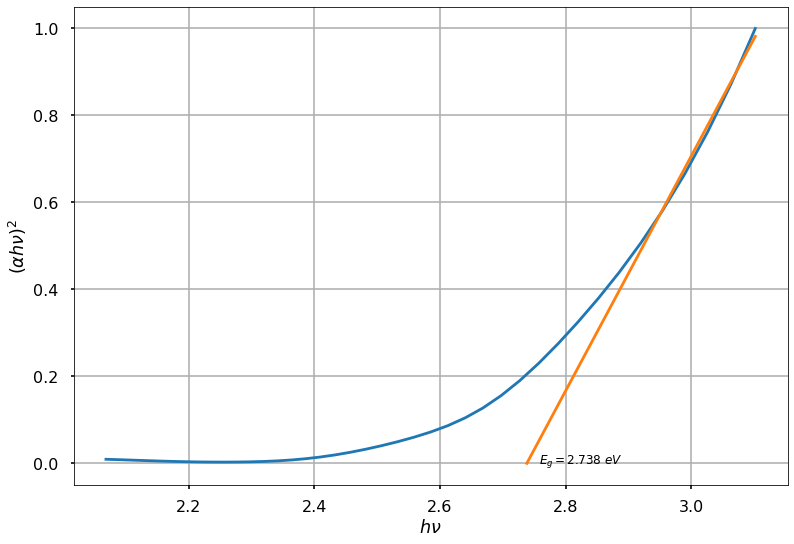

The band gap of material is:  3.811 +- 0.007
Tauc Plot for  znsse for L =  6


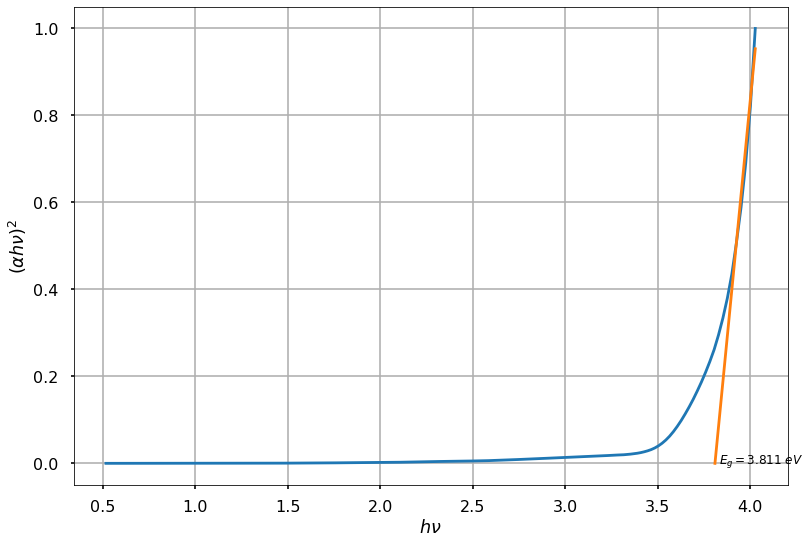

The band gap of material is:  3.528 +- 0.001
Tauc Plot for  znsse2 for L =  6


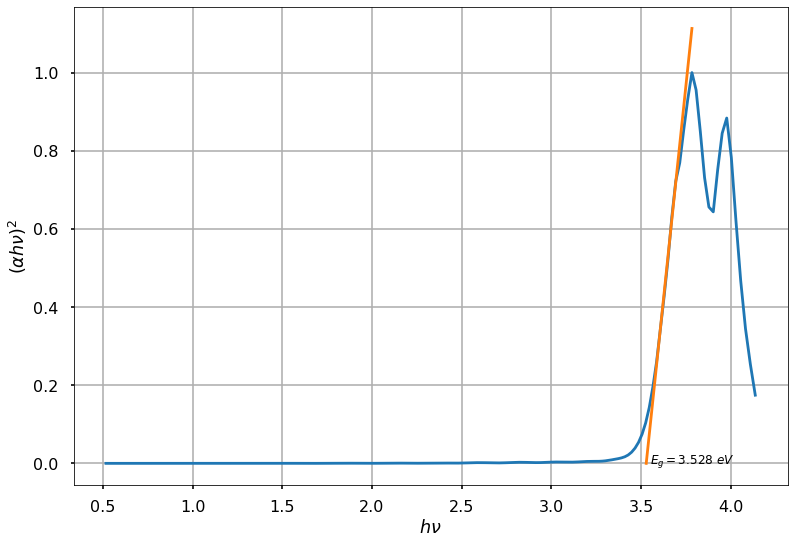

In [ ]:
data = ['https://raw.githubusercontent.com/python4phys1cs/physics-problems/main/calculating-bandgap/data/znse.csv',
        'https://raw.githubusercontent.com/python4phys1cs/physics-problems/main/calculating-bandgap/data/znsse.csv',
        'https://raw.githubusercontent.com/python4phys1cs/physics-problems/main/calculating-bandgap/data/znsse2.csv']

for i in range(len(data)):
  print_output(data[i])